In [ ]:
!pip install tensorflow-gpu==2.0.0-rc1

     |████████████                    | 142.5MB 1.8MB/s eta 0:02:15

In [30]:
!pip install --upgrade tensorflow-gpu


     |████████████████████████████████| 516.2MB 31kB/s 


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
tf.__version__

'2.2.0'

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import PIL
from tensorflow.keras import layers
import time
from google.colab import drive

from IPython import display


In [3]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
f = np.load('/content/drive/My Drive/Colab Notebooks/KDEF_B_train.npy')
train_images = f


In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.
BUFFER_SIZE = len(train_images)
BATCH_SIZE = 125

# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.uniform([num_examples_to_generate, noise_dim])

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [7]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [8]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

In [9]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

generator = make_generator_model()
discriminator = make_discriminator_model()


In [10]:
checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

gene_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
discr_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)

train_log_dir = '/content/drive/My Drive/Colab Notebooks/logs/train/'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [11]:
@tf.function
def train_step(images):
    noise = tf.random.uniform([BATCH_SIZE, noise_dim], seed = 1)
    print(tf.shape(images))
    print(images.shape)
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gene_loss(gen_loss)
        discr_loss(disc_loss)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [12]:
g_loss_t = []
d_loss_t = []
g_loss_v = []
d_loss_v = []


In [13]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        batch_no = 0
        for image_batch in dataset:
            train_step(image_batch)
            batch_no += 1
            if batch_no % 5 == 0:
              print(gene_loss.result().numpy(), discr_loss.result().numpy())
              g_loss_t.append(gene_loss.result().numpy()) 
              d_loss_t.append(discr_loss.result().numpy())
        

        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1,  seed)
        with train_summary_writer.as_default():
            tf.summary.scalar('gen_loss', gene_loss.result(), step=epoch) 
            tf.summary.scalar('disc_loss', discr_loss.result(), step=epoch)
        
        # 15 에포크가 지날 때마다 모델을 저장합니다.
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
        template = 'Epoch {}, gen_loss: {}, disc_loss: {}'
        print(template.format(epoch+1, gene_loss.result(), discr_loss.result()))
        

        # Reset metrics every epoch
        gene_loss.reset_states()
        discr_loss.reset_states()
    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    checkpoint.save(file_prefix = checkpoint_prefix)
    plt.title('Change in cross-entropy loss during training for KDEF_B')
    plt.plot(np.arange(len(g_loss_t)),g_loss_t, label = 'generator')
    plt.plot(np.arange(len(d_loss_t)),d_loss_t, label = 'discriminator')
    plt.legend()
    plt.savefig('/content/drive/My Drive/Colab Notebooks/train_graph.png')
    plt.show()



In [14]:
def generate_and_save_images(model, epoch, test_input):
# `training`이 False로 맞춰진 것을 주목하세요.
# 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('/content/drive/My Drive/Colab Notebooks/images/KDEF_B_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

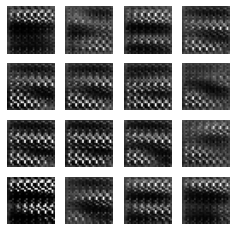

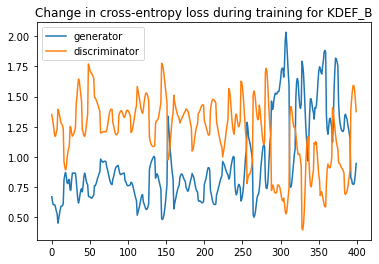

CPU times: user 1min 20s, sys: 11.8 s, total: 1min 32s
Wall time: 2min 36s


In [15]:
%%time
train(train_dataset, EPOCHS)

In [16]:
def valid(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        batch_no = 0
        checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
        for image_batch in dataset:
            valid_step(image_batch)
            batch_no += 1
            if batch_no % 5 == 0:
              print(gene_loss.result().numpy(), discr_loss.result().numpy())
              g_loss_v.append(gene_loss.result().numpy()) 
              d_loss_v.append(discr_loss.result().numpy())


        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1,  seed)
        with train_summary_writer.as_default():
            tf.summary.scalar('gen_loss', gene_loss.result(), step=epoch) 
            tf.summary.scalar('disc_loss', discr_loss.result(), step=epoch)
        
    
        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
        template = 'Epoch {}, gen_loss: {}, disc_loss: {}'
        print(template.format(epoch+1, gene_loss.result(), discr_loss.result()))

        # Reset metrics every epoch
        gene_loss.reset_states()
        discr_loss.reset_states()
    # 마지막 에포크가 끝난 후 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)
    plt.title('Change in cross-entropy loss during validation for KDEF_B')
    plt.plot(np.arange(len(g_loss_v)),g_loss_v, label = 'generator')
    plt.plot(np.arange(len(d_loss_v)),d_loss_v, label = 'discriminator')
    plt.legend()
    plt.savefig('/content/drive/My Drive/Colab Notebooks/valid_graph.png')
    plt.show()

In [17]:
v = np.load('/content/drive/My Drive/Colab Notebooks/KDEF_B_valid.npy')
valid_images = v
valid_images = valid_images.reshape(valid_images.shape[0], 28, 28, 1).astype('float32')
valid_images = (valid_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.
BUFFER_SIZE = len(valid_images)
BATCH_SIZE = 125

# 데이터 배치를 만들고 섞습니다.
valid_dataset = tf.data.Dataset.from_tensor_slices(valid_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

In [18]:
@tf.function
def valid_step(images):
    noise = tf.random.uniform([BATCH_SIZE, noise_dim], seed = 1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=False)
        real_output = discriminator(images, training=False)
        fake_output = discriminator(generated_images, training=False)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gene_loss(gen_loss)
        discr_loss(disc_loss)


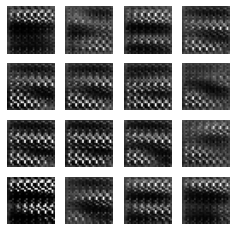

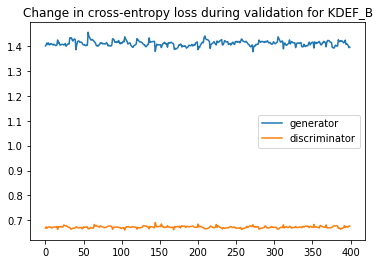

CPU times: user 56.8 s, sys: 7.53 s, total: 1min 4s
Wall time: 1min 28s


In [19]:
%%time
valid(valid_dataset, EPOCHS)

In [20]:
loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
ms = []

In [21]:
@tf.function
def test_step(images):
    noise = tf.random.uniform([BATCH_SIZE, noise_dim], seed = 1)
    generated_images = generator(noise, training=False)
    print(images, generated_images)
    mse = tf.keras.losses.MSE(generated_images, images)
    loss(mse)



In [22]:
def test(dataset, epochs):
    sum_mse = 0
    for epoch in range(epochs):
        start = time.time()
        batch_no = 0
        checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
        i=0
        for image_batch in dataset:
            test_step(image_batch)
            # print(loss.result().numpy())
            ms.append(loss.result().numpy())
        
        # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    


    # 마지막 에포크가 끝난 후 생성합니다.
    for i in range(len(ms)):
      sum_mse += ms[i]
    print(sum_mse/len(ms))


In [23]:
t = np.load('/content/drive/My Drive/Colab Notebooks/KDEF_B_test.npy')
test_images = t
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.
BUFFER_SIZE = len(test_images)
BATCH_SIZE = 50

# 데이터 배치를 만들고 섞습니다.
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

In [24]:
%%time
test(test_dataset,EPOCHS)

Tensor("images:0", shape=(50, 28, 28, 1), dtype=float32) Tensor("sequential/conv2d_transpose_2/Tanh:0", shape=(50, 28, 28, 1), dtype=float32)
Time for epoch 1 is 0.5893633365631104 sec
Time for epoch 2 is 0.40184855461120605 sec
Time for epoch 3 is 0.42512989044189453 sec
Time for epoch 4 is 0.44271111488342285 sec
Time for epoch 5 is 0.4618692398071289 sec
Time for epoch 6 is 0.43834614753723145 sec
Time for epoch 7 is 0.45777082443237305 sec
Time for epoch 8 is 0.4611666202545166 sec
Time for epoch 9 is 0.45574045181274414 sec
Time for epoch 10 is 0.43785715103149414 sec
0.21982754036784172
CPU times: user 1.9 s, sys: 1.08 s, total: 2.98 s
Wall time: 4.57 s
